# Arctic TOA Flux Analysis using CERES EBAF Data

This notebook analyzes Top-of-Atmosphere (TOA) radiation fluxes (Shortwave, Longwave, and Net) over the Arctic using the CERES_EBAF Ed4.2.1 dataset. The goal is to investigate trends in energy balance components and interpret the phenomenon of Arctic Amplification.

In [1]:
# Arctic TOA Flux Analysis using CERES EBAF Data

# This notebook analyzes TOA radiation fluxes over the Arctic (SW, LW, Net)
# using CERES_EBAF Ed4.2.1 data and explores trends related to Arctic Amplification

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
file_name = 'CERES_EBAF-TOA_Ed4.2.1_Subset_200003-202502.nc'
root = nc.Dataset(file_name, 'r')

### Retrieve the TOA flux data and geographic information
lon = np.array(root['lon'][:])
lat = np.array(root['lat'][:])
lat_w = np.cos(np.deg2rad(lat))
time = np.array(root['time'][:])

# Clear naming convention for different flux components
toa_sw_refl_mon = np.array(root['toa_sw_all_mon'][:,:,:])  # Reflected SW flux
toa_lw_mon = np.array(root['toa_lw_all_mon'][:,:,:])       # Outgoing LW flux
toa_net_mon = np.array(root['toa_net_all_mon'][:,:,:])     # Net TOA flux
toa_sw_inc_mon = np.array(root['solar_mon'][:,:,:])        # Incoming solar flux
toa_sw_net_mon = toa_sw_inc_mon - toa_sw_refl_mon          # Net incoming SW flux



/tmp/ipykernel_121763/382785874.py:11: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  toa_sw_refl_mon = np.array(root['toa_sw_all_mon'][:,:,:])  # Reflected SW flux
/tmp/ipykernel_121763/382785874.py:11: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  toa_sw_refl_mon = np.array(root['toa_sw_all_mon'][:,:,:])  # Reflected SW flux
/tmp/ipykernel_121763/382785874.py:12: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  toa_lw_mon = np.array(root['toa_lw_all_mon'][:,:,:])       # Outgoing LW flux
/tmp/ipykernel_121763/382785874.py:12: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  toa_lw_mon = np.array(root['toa_lw_all_mon'][:,:,:])       # Outgoing LW flux
/tmp/ipykernel_121763/382785874.py:13: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  toa_net_mon

## Functions for computation and plotting

In [3]:
def compute_lat_weighted_mean(data, lat):
    lat_weights = np.cos(np.deg2rad(lat))
    global_mean = np.zeros(data.shape[0])
    for t in range(data.shape[0]):
        monthly_data = data[t, :, :]
        zonal_mean = np.mean(monthly_data, axis=1)
        global_mean[t] = np.average(zonal_mean, weights=lat_weights)
    return global_mean

def compute_annual_mean(monthly_series, start_year=2000):
    n_months = len(monthly_series)
    n_years = n_months // 12
    annual_series = np.zeros(n_years)
    for y in range(n_years):
        annual_series[y] = np.mean(monthly_series[y * 12:(y + 1) * 12])
    years = np.arange(start_year, start_year + n_years)
    return years, annual_series


In [4]:
def plot_flux_subplots(x, sw, lw, net, is_annual=False, time_label='Time', save_path=None, sw_label='TOA SW Flux'):
    """
    Generalized plot for TOA fluxes with customizable SW label.
    
    Parameters:
    - x: time axis
    - sw: shortwave data
    - lw: longwave data
    - net: net flux data
    - sw_label: custom label for SW (e.g., "TOA SW Reflected Flux" or "TOA SW Net Flux")
    """
    lw_width = 2 if is_annual else 1
    sw_trend = np.poly1d(np.polyfit(x, sw, 1))
    lw_trend = np.poly1d(np.polyfit(x, lw, 1))
    net_trend = np.poly1d(np.polyfit(x, net, 1))

    fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

    axs[0].plot(x, sw, color='orange', linewidth=lw_width, label=sw_label)
    axs[0].plot(x, sw_trend(x), 'k--', linewidth=1.5, label='Trend')
    axs[0].set_ylabel('Flux (W/m²)')
    axs[0].set_title(sw_label)
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(x, lw, color='blue', linewidth=lw_width, label='TOA LW Flux')
    axs[1].plot(x, lw_trend(x), 'k--', linewidth=1.5, label='Trend')
    axs[1].set_ylabel('Flux (W/m²)')
    axs[1].set_title('TOA LW Flux')
    axs[1].grid(True)
    axs[1].legend()

    axs[2].plot(x, net, color='green', linewidth=lw_width, label='TOA Net Flux')
    axs[2].plot(x, net_trend(x), 'k--', linewidth=1.5, label='Trend')
    axs[2].set_xlabel(time_label)
    axs[2].set_ylabel('Flux (W/m²)')
    axs[2].set_title('TOA Net Flux')
    axs[2].grid(True)
    axs[2].legend()

    fig.suptitle('Arctic: ' + ('Annual' if is_annual else 'Monthly') + ' TOA Fluxes', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()



In [5]:
def compute_arctic_seasonal_means_w(data, lat, time, start_year=2000, start_month=3):
    weighted_monthly = compute_lat_weighted_mean(data, lat)
    n_months = len(time)
    n_years = n_months // 12 + 1  # se suma uno por los inviernos extendidos

    summer_means = []
    winter_means = []
    summer_years = []
    winter_years = []

    # Ajuste para CERES (inicio en marzo)
    summer_indices = [3, 4, 5, 6, 7, 8]    # Abr–Sep
    winter_indices = [9, 10, 11, 0, 1, 2]  # Oct–Mar

    for y in range(n_years):
        # ------ SUMMER ------
        summer_vals = []
        for m in summer_indices:
            idx = y * 12 + m
            if idx < n_months:
                summer_vals.append(weighted_monthly[idx])
        if len(summer_vals) >= 2 and not np.isnan(summer_vals).all():
            summer_means.append(np.nanmean(summer_vals))
            summer_years.append(start_year + y)

        # ------ WINTER ------
        winter_vals = []
        for m in winter_indices:
            idx = y * 12 + m if m >= 3 else (y + 1) * 12 + m
            if idx < n_months:
                winter_vals.append(weighted_monthly[idx])
        if len(winter_vals) >= 2 and not np.isnan(winter_vals).all():
            winter_means.append(np.nanmean(winter_vals))
            winter_years.append(start_year + y)

    return (
        np.array(summer_years),
        np.array(winter_years),
        np.array(summer_means),
        np.array(winter_means)
    )


def plot_seasonal_subplots(years, sw, lw, net, season='Summer', y_label='Flux (W/m²)', save_path=None):
    # Filtrar valores válidos para evitar errores de ajuste
    valid = ~np.isnan(sw) & ~np.isnan(lw) & ~np.isnan(net) & ~np.isnan(years)
    years = years[valid]
    sw = sw[valid]
    lw = lw[valid]
    net = net[valid]

    fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

    sw_trend = np.poly1d(np.polyfit(years, sw, 1))
    lw_trend = np.poly1d(np.polyfit(years, lw, 1))
    net_trend = np.poly1d(np.polyfit(years, net, 1))

    axs[0].plot(years, sw, 'orange', marker='o')
    axs[0].plot(years, sw_trend(years), 'k--')
    axs[0].set_title(f'{season}: TOA Shortwave Flux')
    axs[0].set_ylabel(y_label)
    axs[0].grid(True)

    axs[1].plot(years, lw, 'blue', marker='o')
    axs[1].plot(years, lw_trend(years), 'k--')
    axs[1].set_title(f'{season}: TOA Longwave Flux')
    axs[1].set_ylabel(y_label)
    axs[1].grid(True)

    axs[2].plot(years, net, 'green', marker='o')
    axs[2].plot(years, net_trend(years), 'k--')
    axs[2].set_title(f'{season}: TOA Net Flux')
    axs[2].set_xlabel('Year')
    axs[2].set_ylabel(y_label)
    axs[2].grid(True)

    fig.suptitle(f'Arctic: TOA {season} Fluxes', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()



In [6]:
def plot_sw_components(x, incident, reflected, net, title="SW Flux Components", time_label='Year', save_path=None):
   
    fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
    
    # Incident Solar Flux
    inc_trend = np.poly1d(np.polyfit(x, incident, 1))
    axs[0].plot(x, incident, color='red', linewidth=2, label='Incident Solar Flux')
    axs[0].plot(x, inc_trend(x), 'k--', linewidth=1.5, label='Trend')
    axs[0].set_ylabel('Flux (W/m²)')
    axs[0].set_title('Incident Solar Flux')
    axs[0].grid(True)
    axs[0].legend()
    
    # Reflected SW Flux
    ref_trend = np.poly1d(np.polyfit(x, reflected, 1))
    axs[1].plot(x, reflected, color='orange', linewidth=2, label='Reflected SW Flux')
    axs[1].plot(x, ref_trend(x), 'k--', linewidth=1.5, label='Trend')
    axs[1].set_ylabel('Flux (W/m²)')
    axs[1].set_title('Reflected SW Flux')
    axs[1].grid(True)
    axs[1].legend()
    
    # Net Incoming SW Flux
    net_trend = np.poly1d(np.polyfit(x, net, 1))
    axs[2].plot(x, net, color='purple', linewidth=2, label='Net Incoming SW Flux')
    axs[2].plot(x, net_trend(x), 'k--', linewidth=1.5, label='Trend')
    axs[2].set_xlabel(time_label)
    axs[2].set_ylabel('Flux (W/m²)')
    axs[2].set_title('Net Incoming SW Flux')
    axs[2].grid(True)
    axs[2].legend()
    
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

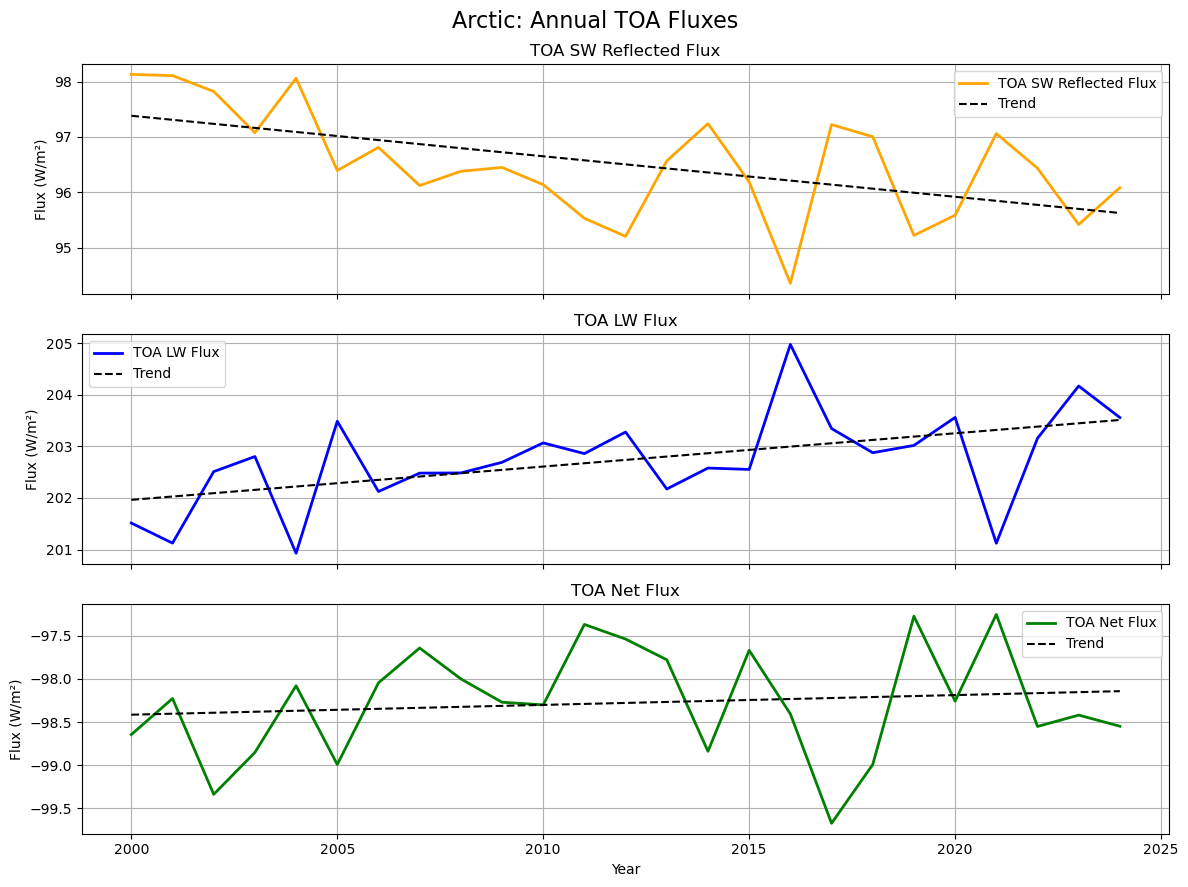

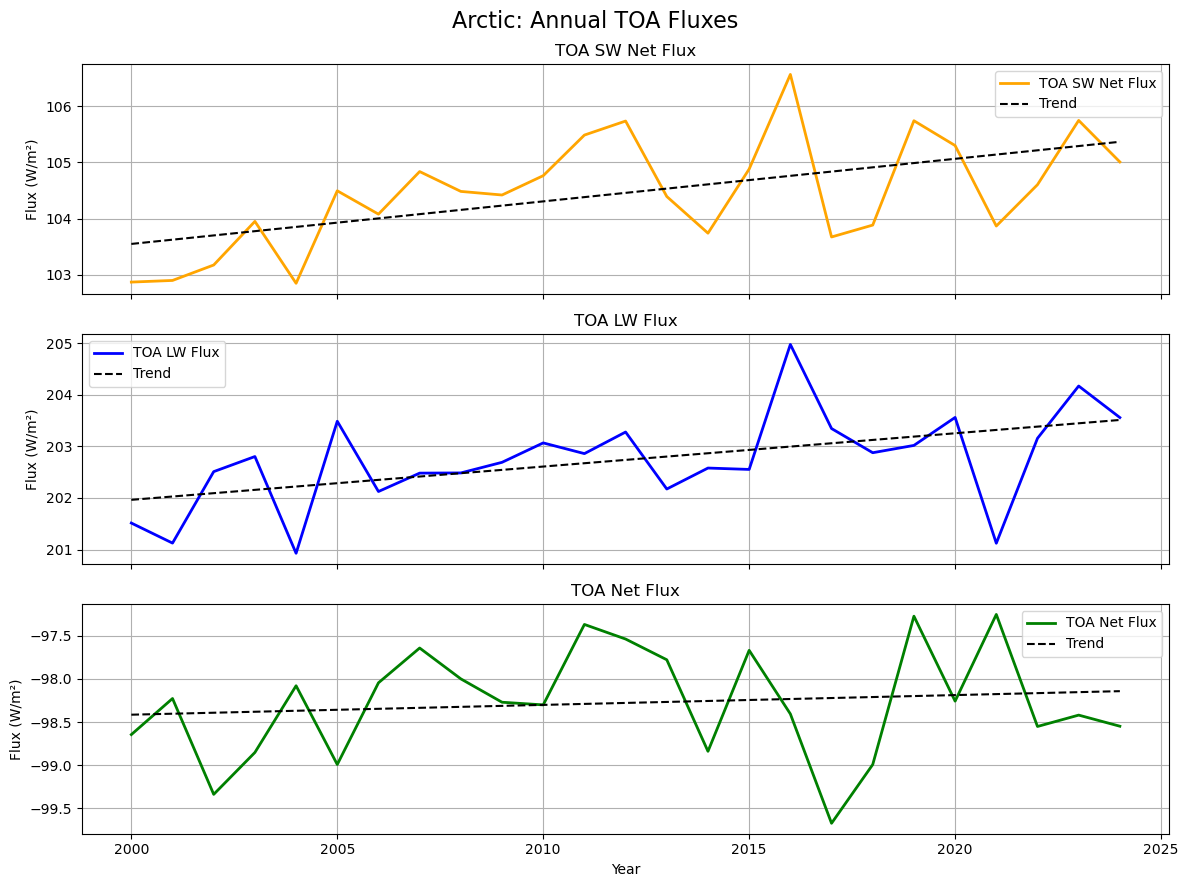

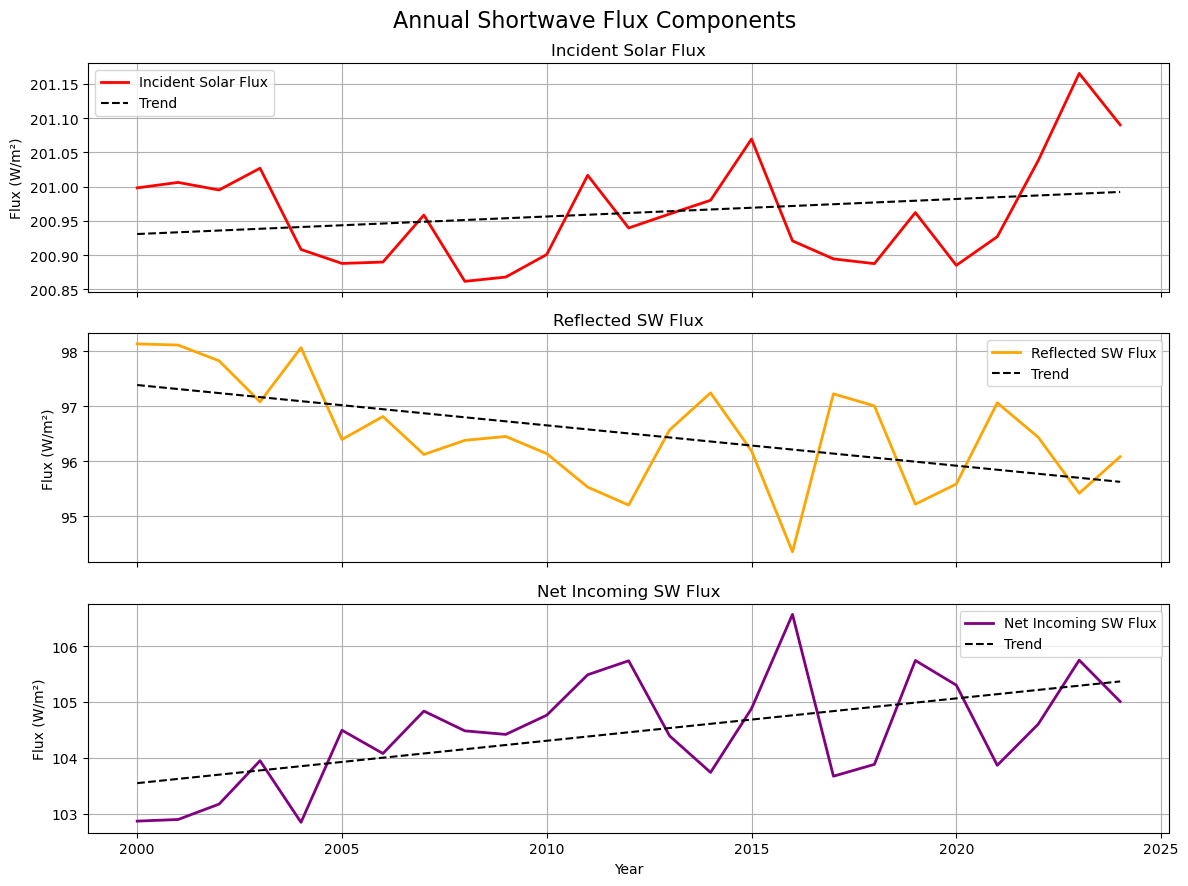

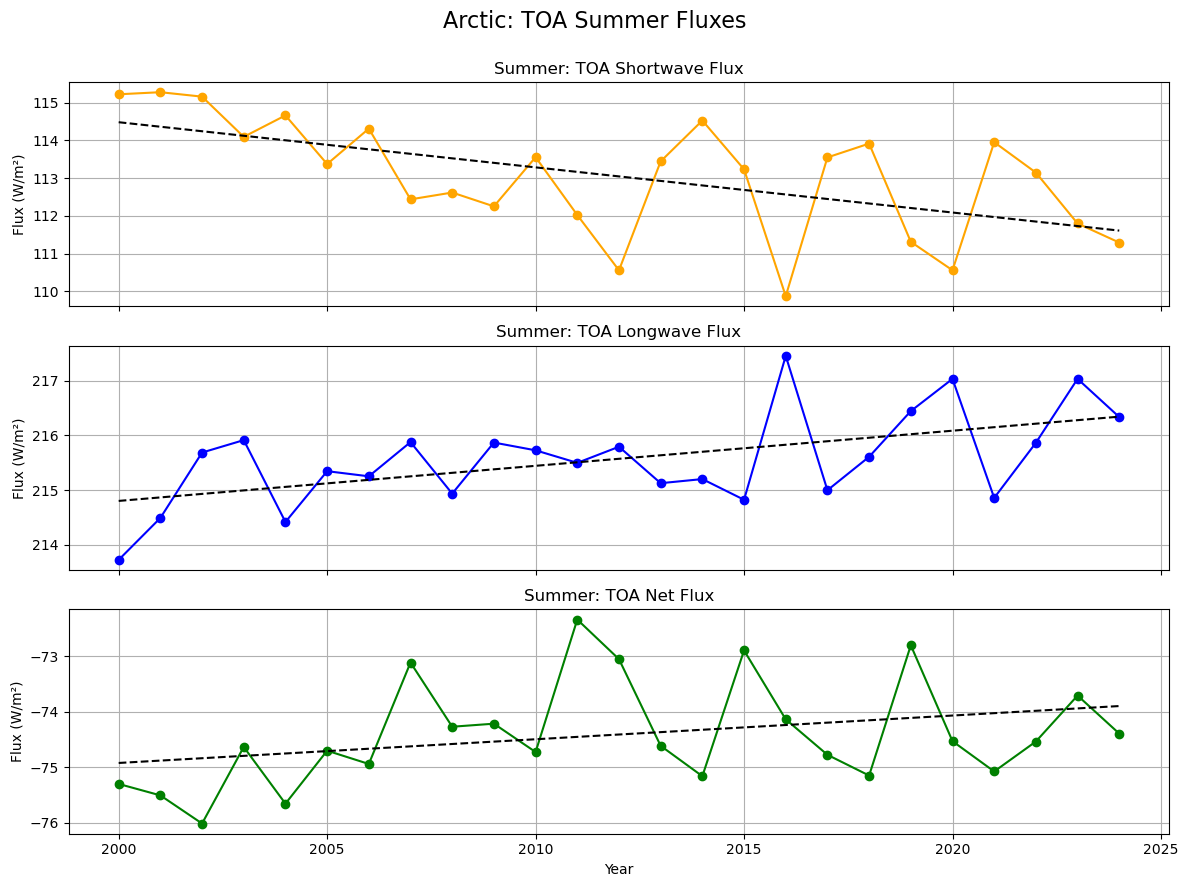

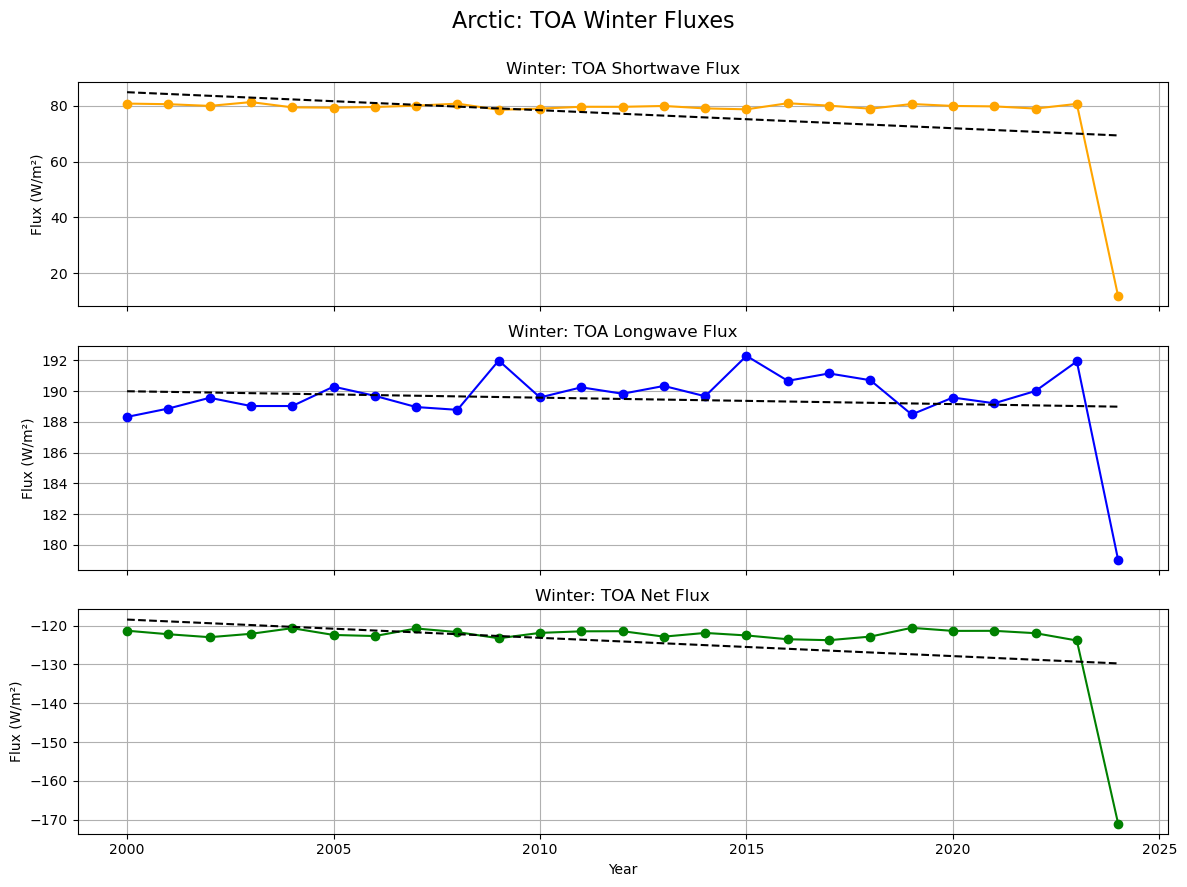

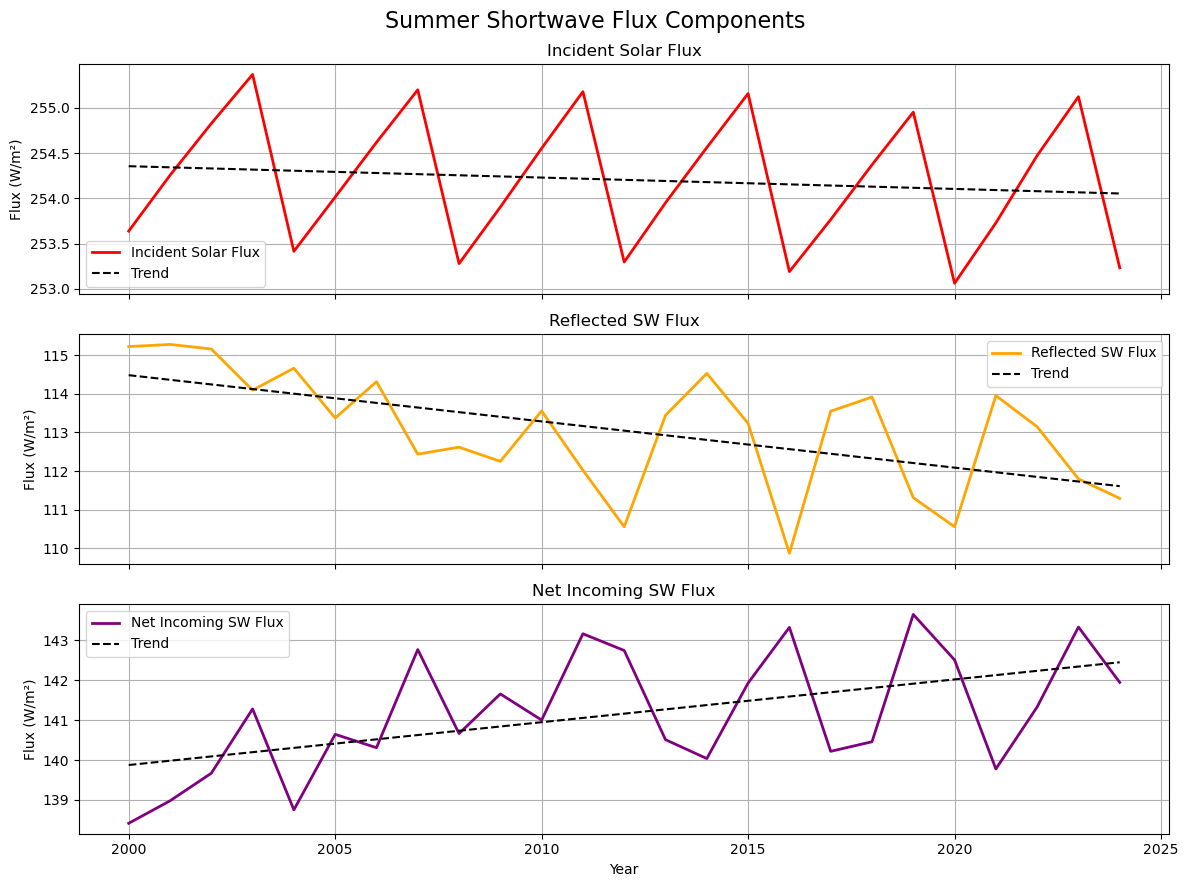

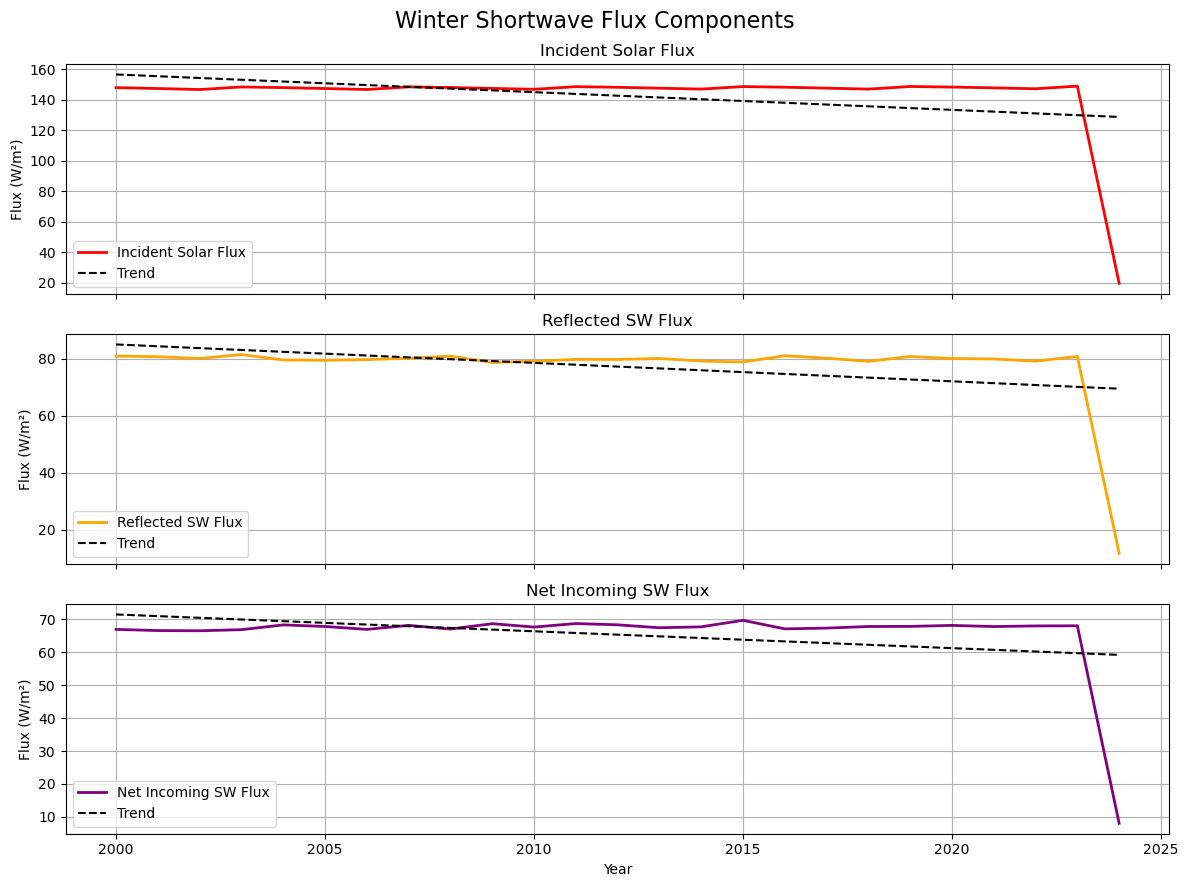

In [7]:
# Calculate global means using latitude weighting
toa_sw_refl_mon_mean = compute_lat_weighted_mean(toa_sw_refl_mon, lat)
toa_lw_mon_mean     = compute_lat_weighted_mean(toa_lw_mon, lat)
toa_net_mon_mean    = compute_lat_weighted_mean(toa_net_mon, lat)
toa_sw_inc_mon_mean = compute_lat_weighted_mean(toa_sw_inc_mon, lat)
toa_sw_net_mon_mean = compute_lat_weighted_mean(toa_sw_net_mon, lat)

# Calculate annual means
years, toa_sw_refl_annual = compute_annual_mean(toa_sw_refl_mon_mean, start_year=2000)
years, toa_lw_annual      = compute_annual_mean(toa_lw_mon_mean,     start_year=2000)
years, toa_net_annual     = compute_annual_mean(toa_net_mon_mean,    start_year=2000)
years, toa_sw_inc_annual  = compute_annual_mean(toa_sw_inc_mon_mean, start_year=2000)
years, toa_sw_net_annual  = compute_annual_mean(toa_sw_net_mon_mean, start_year=2000)

# Calculate Arctic seasonal means
arctic_summer_years, arctic_winter_years, arctic_sw_refl_summer, arctic_sw_refl_winter = compute_arctic_seasonal_means_w(
    toa_sw_refl_mon, lat, time, 2000, 3)
_, _, arctic_lw_summer, arctic_lw_winter = compute_arctic_seasonal_means_w(
    toa_lw_mon, lat, time, 2000, 3)
_, _, arctic_net_summer, arctic_net_winter = compute_arctic_seasonal_means_w(
    toa_net_mon, lat, time, 2000, 3)
_, _, arctic_sw_inc_summer, arctic_sw_inc_winter = compute_arctic_seasonal_means_w(
    toa_sw_inc_mon, lat, time, 2000, 3)
_, _, arctic_sw_net_summer, arctic_sw_net_winter = compute_arctic_seasonal_means_w(
    toa_sw_net_mon, lat, time, 2000, 3)

# Setup time axis
months = np.arange(len(time))
years_from_time = 2000 + months / 12

# Plot the original annual fluxes (reflected SW, LW, net)
plot_flux_subplots(
    x=years,
    sw=toa_sw_refl_annual,
    lw=toa_lw_annual,
    net=toa_net_annual,
    is_annual=True,
    time_label='Year',
    save_path='plot_annual_fluxes_reflected.png',
    sw_label='TOA SW Reflected Flux'
)

# Plot the net annual fluxes (net incoming SW, LW, net)
plot_flux_subplots(
    x=years,
    sw=toa_sw_net_annual,
    lw=toa_lw_annual,
    net=toa_net_annual,
    is_annual=True,
    time_label='Year',
    save_path='plot_annual_fluxes_net_sw.png',
    sw_label='TOA SW Net Flux'
)

# Plot the annual SW components (incident, reflected, net)
plot_sw_components(
    x=years,
    incident=toa_sw_inc_annual,
    reflected=toa_sw_refl_annual,
    net=toa_sw_net_annual,
    title="Annual Shortwave Flux Components",
    save_path='annual_sw_components.png'
)

# Summer fluxes
plot_seasonal_subplots(
    arctic_summer_years,
    arctic_sw_refl_summer,
    arctic_lw_summer,
    arctic_net_summer,
    season='Summer',
    save_path='summer_toa_flux.png'
)

# Winter fluxes
plot_seasonal_subplots(
    arctic_winter_years,
    arctic_sw_refl_winter,
    arctic_lw_winter,
    arctic_net_winter,
    season='Winter',
    save_path='winter_toa_flux.png'
)

# Plot seasonal SW components (Summer)
plot_sw_components(
    x=arctic_summer_years,
    incident=arctic_sw_inc_summer,
    reflected=arctic_sw_refl_summer,
    net=arctic_sw_net_summer,
    title="Summer Shortwave Flux Components",
    save_path='summer_sw_components.png'
)

# Plot seasonal SW components (Winter)
plot_sw_components(
    x=arctic_winter_years,
    incident=arctic_sw_inc_winter,
    reflected=arctic_sw_refl_winter,
    net=arctic_sw_net_winter,
    title="Winter Shortwave Flux Components",
    save_path='winter_sw_components.png'
)


## Arctic Amplification Summary

These results show clear evidence of Arctic Amplification:
- Increasing LW flux indicates surface and atmospheric warming.
- Slight decline in SW flux may be linked to changes in sea ice and albedo.
- Less negative Net flux means more energy is retained in the Arctic system.

These energy trends reflect the enhanced warming rate of the Arctic compared to the global average.

In [8]:
# NOTE: wrapped so batch execution doesn't fail if variables aren't defined yet
try:
    print("Years:", len(arctic_years))
    print("SW   :", len(arctic_sw_refl_summer))
    print("LW   :", len(arctic_lw_summer))
    print("Net  :", len(arctic_net_summer))
except NameError as e:
    print("Skipping length-check cell (variables undefined in fresh run):", e)


Skipping length-check cell (variables undefined in fresh run): name 'arctic_years' is not defined
